C:\Users\HT\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


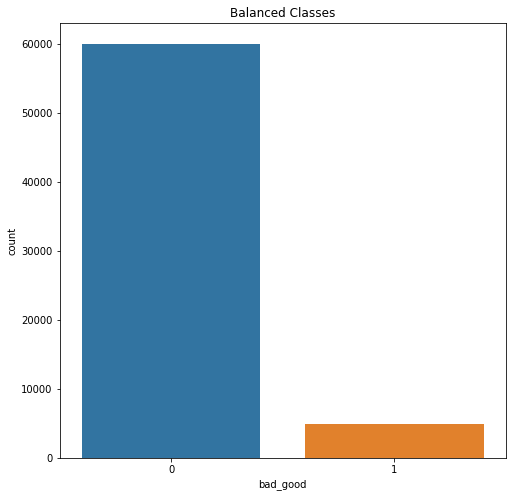

C:\Users\HT\AppData\Local\Temp/ipykernel_6016/12719148.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(df.columns):


  0%|          | 0/627 [00:00<?, ?it/s]

原始的train shape :          index     CUST_ID  OPEN_ORG_NUM  IDF_TYP_CD  GENDER  bad_good  \
0       44801  1118058357          2201           0       0         1   
1       41032  1112429011           323           0       1         1   
2      104634  1212000096          1606           0       0         1   
3       98098  1204925593           805           0       0         1   
4       34886  1103626741           126           0       0         1   
...       ...         ...           ...         ...     ...       ...   
64879  195669  1295094380          1202           0       1         0   
64880   42118  1114342086          1101           0       1         0   
64881   35347  1104174959           213           0       1         0   
64882   20045  1078273308           908           0       1         0   
64883  222640  1316234767           501           0       0         0   

       LAST_OPEN_TENURE_DAYS  G_OS_PRCP_SUM  OS_PRCP_SUM_THREE  \
0                         17           

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
#import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import seaborn as sns
#----------------------------------------------------------------------------------
# 1: 加载数据文件，查看数据信息
df = pd.read_csv("C:\\Users\\HT\\Desktop\\论文\Real\\train.csv")
df.head() # broadband 即可：0-离开，1-留存
df_test = pd.read_csv("C:\\Users\\HT\\Desktop\\论文\\Real\\test.csv")

# Shuffle the Dataset.
shuffled_df = df.sample(frac=1,random_state=4)
# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['bad_good'] == 1]
#Randomly select 492 observations from the non-fraud (majority class)
non_fraud_df=shuffled_df.loc[shuffled_df['bad_good']== 0].sample(n=60000,random_state=42)
# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])
#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('bad_good', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

df = normalized_df

from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
# LabelEncoder
for col in tqdm_notebook(df.columns):
    if df[col].dtype == "object":
        encoder = LabelEncoder()
        encoder.fit(list(df[col].values) + list(df_test[col].values))
        df[col] = encoder.transform(list(df[col].values))
        df_test[col] = encoder.transform(list(df_test[col].values))
        
df = df.reset_index() # 重置索引
df_test = df_test.reset_index()
def clean_top_cols(df):
    new_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.95]
    return new_cols
df_cols = clean_top_cols(df)
df_test_clos = clean_top_cols(df_test)
cols_to_drop = list(set(df_cols + df_test_clos))
if 'bad_good' in cols_to_drop : # 查看标签列是否在其中
    cols_to_drop.remove('bad_good') # 删除标签列
print("原始的train shape : ", df)
df = df.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)
print("清理后的train shape : ", df.shape)
#df.to_csv(r"Import_90.csv",sep=',')
print(df.shape)
y = df['bad_good'] # 标签
X1 = df.iloc[:, 1:-1] # 客户 id 没有用，故丢弃 cust_id

In [17]:
# import numpy as np
# import pandas as pd
# from tensorflow.keras.optimizers import Adam
# #import cv2
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import img_to_array
# from sklearn.model_selection import train_test_split
# from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.models import load_model
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns

# df = pd.read_csv('Train_New.csv')
# df.head() # broadband 即可：0-离开，1-留存
# df_test = pd.read_csv('test.csv')
# #y = df['bad_good'] # 标签
# #X1 = df.iloc[:, 1:-1] # 客户 id 没有用，故丢弃 cust_id
X1 = df.sort_values('CUST_ID').drop(['bad_good', 'CUST_ID','index'], axis=1)
y = df.sort_values('CUST_ID')['bad_good']

In [18]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import catboost as cb
#from sklearn.datasets import load_breast_cancer
X_train, X_validation, y_train, y_validation = train_test_split(X1,y,test_size=0.3 , random_state=0)

cat_features_index = [0,1,2,3,4,5,6]
 
def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_validation,m.predict_proba(test)[:,1]))

params = {'depth': [4, 7, 10],
          'loss_function': ['Logloss'],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300,400,500]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 5)
cb.fit(X_train, y_train)
#cb_model.fit(X_train, y_train)
#print(cb_model.best_params_)

print("accuracy on the training subset:{:.3f}".format(cb.score(X_train,y_train)))
print("accuracy on the training subset:{:.3f}".format(cb.score(X_train,y_train)))
print("AUC on the training subset:{:.3f}".format(roc_auc_score(cb.predict(X_validation),y_validation)))
print(cb.get_best_iteration())
print(cb.get_params())
print(cb.get_best_score())

Learning rate set to 0.05255
0:	learn: 0.6249109	total: 148ms	remaining: 2m 27s
1:	learn: 0.5643419	total: 300ms	remaining: 2m 29s
2:	learn: 0.5137722	total: 453ms	remaining: 2m 30s
3:	learn: 0.4801420	total: 572ms	remaining: 2m 22s
4:	learn: 0.4412229	total: 691ms	remaining: 2m 17s
5:	learn: 0.4136612	total: 796ms	remaining: 2m 11s
6:	learn: 0.3832042	total: 931ms	remaining: 2m 12s
7:	learn: 0.3551439	total: 1.05s	remaining: 2m 10s
8:	learn: 0.3361511	total: 1.18s	remaining: 2m 10s
9:	learn: 0.3181569	total: 1.3s	remaining: 2m 9s
10:	learn: 0.3070193	total: 1.42s	remaining: 2m 7s
11:	learn: 0.2960423	total: 1.51s	remaining: 2m 4s
12:	learn: 0.2795104	total: 1.64s	remaining: 2m 4s
13:	learn: 0.2696448	total: 1.75s	remaining: 2m 3s
14:	learn: 0.2617060	total: 1.86s	remaining: 2m 1s
15:	learn: 0.2502174	total: 1.99s	remaining: 2m 2s
16:	learn: 0.2433099	total: 2.1s	remaining: 2m 1s
17:	learn: 0.2367697	total: 2.23s	remaining: 2m 1s
18:	learn: 0.2301739	total: 2.35s	remaining: 2m 1s
19:	l

C:\Users\HT\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


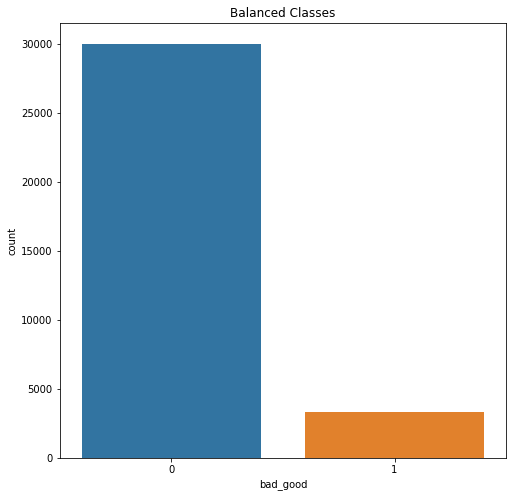

In [8]:
# Shuffle the Dataset.
shuffled_df = df_test.sample(frac=1,random_state=4)
# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['bad_good'] == 1]
#Randomly select 492 observations from the non-fraud (majority class)
non_fraud_df=shuffled_df.loc[shuffled_df['bad_good']== 0].sample(n=30000,random_state=42)
# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df])
#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('bad_good', data=normalized_df)
plt.title('Balanced Classes')
plt.show()
df_test = non_fraud_df

In [19]:
df_test_pred = df_test.sort_values('CUST_ID').drop(['bad_good', 'CUST_ID','index'], axis=1)
#df_test_pred = df_test.iloc[:, 1:-1]
y_test_pred = cb.predict(df_test_pred)

In [20]:
from sklearn.metrics import accuracy_score,roc_auc_score
import numpy as np
from sklearn import metrics
CatBoost_score = accuracy_score(df_test["bad_good"],y_test_pred)
# gbm_score=accuracy_score(test["bad_good"],y_test_predict1)
print(f" 测试集的 Accuracy ： { CatBoost_score * 100}%")
auc = roc_auc_score(df_test["bad_good"], y_test_pred)
print(f" 测试集的 AUC_ROC ： { auc * 100}%")

 测试集的 Accuracy ： 97.89477567108966%
 测试集的 AUC_ROC ： 65.30538244421331%


In [9]:
dataframe = pd.DataFrame({'bad_good':y_test_pred})
dataframe.to_csv('result_CAT.csv')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0159806	test: 0.0154884	best: 0.0154884 (0)	total: 1.96s	remaining: 1m 36s
1:	learn: 0.0051288	test: 0.0049273	best: 0.0049273 (1)	total: 3.15s	remaining: 1m 15s
2:	learn: 0.0040151	test: 0.0039242	best: 0.0039242 (2)	total: 4.2s	remaining: 1m 5s
3:	learn: 0.0036432	test: 0.0036777	best: 0.0036777 (3)	total: 5.62s	remaining: 1m 4s
4:	learn: 0.0035205	test: 0.0036579	best: 0.0036579 (4)	total: 6.93s	remaining: 1m 2s
5:	learn: 0.0035202	test: 0.0036585	best: 0.0036579 (4)	total: 8.06s	remaining: 59.1s
6:	learn: 0.0035176	test: 0.0036520	best: 0.0036520 (6)	total: 9.22s	remaining: 56.6s
7:	learn: 0.0034860	test: 0.0036515	best: 0.0036515 (7)	total: 10.5s	remaining: 55.1s
8:	learn: 0.0033871	test: 0.0036309	best: 0.0036309 (8)	total: 11.7s	remaining: 53.1s
9:	learn: 0.0033766	test: 0.0036241	best: 0.0036241 (9)	total: 12.6s	remaining: 50.4s
10:	learn: 0.0033766	test: 0.0036241	best: 0.0036241 (10)	total: 13.2s	remaining: 46.7s
11:	learn: 0.0033483	test: 0.0036277	best: 0.003624

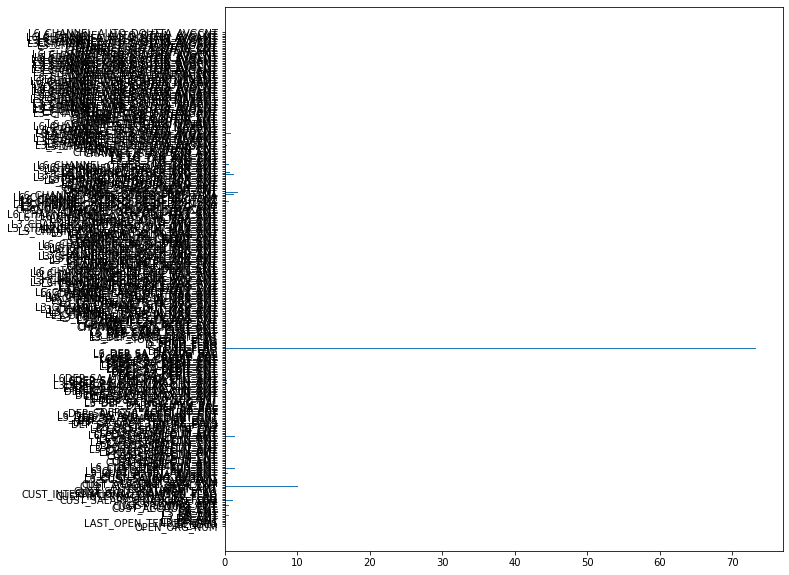

In [3]:
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
#data  = pd.read_csv("ctr_train.txt", delimiter="\t")
#del data["user_tags"]
#data = data.fillna(0)
X_train, X_validation, y_train, y_validation = train_test_split(X1,y,test_size=0.3 , random_state=1234)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
model = CatBoostClassifier(iterations=50, depth=5,cat_features=categorical_features_indices,
                           learning_rate=0.5, loss_function='Logloss',
                            logging_level='Verbose', 
                            #custom_metric=['Logloss', 'AUC:hints=skip_train~false'])
                            custom_metric=['Accuracy'])

model.fit(X_train,y_train,eval_set=(X_validation, y_validation),plot=True)

#preds_class = model.predict(y_train)

# 预测每个类别的可能性
#preds_proba = model.predict_proba(y_train)

# 预测Raw formula value
#preds_raw = model.predict(y_train, prediction_type='RawFormulaVal')

import matplotlib.pyplot as plt 
fea_ = model.feature_importances_
fea_name = model.feature_names_
plt.figure(figsize=(10, 10))
plt.barh(fea_name,fea_,height =0.5)
print(model.get_best_score())

In [10]:
#data[cat_features] = data[cat_features].astype(str)
df_test = df_test.astype(int)
df_test['CUST_AUM'] = df_test['CUST_AUM'].astype(float)
y_test_pred = model.predict(df_test)
dataframe = pd.DataFrame({'bad_good':y_test_pred})
dataframe.to_csv('result_CAT.csv')

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=17]=3584.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [7]:
print(model.get_best_score())
print(model.get_best_iteration())

{'learn': {'Accuracy': 0.9994491710023585, 'Logloss': 0.002138179573891947}, 'validation': {'Accuracy': 0.9990302152221158, 'Logloss': 0.0033782750210819227}}
47
